In [3]:
import pandas as pd

# Load all files to check their structure
sales_receipts = pd.read_csv(r"Datasets\CoffeeShopDataset\201904 sales reciepts.csv")
customer = pd.read_csv(r"Datasets\CoffeeShopDataset\customer.csv")
dates = pd.read_csv(r"Datasets\CoffeeShopDataset\dates.csv")
generations = pd.read_csv(r"Datasets\CoffeeShopDataset\generations.csv")
pastry_inventory = pd.read_csv(r"Datasets\CoffeeShopDataset\pastry inventory.csv")
product = pd.read_csv(r"Datasets\CoffeeShopDataset\product.csv")
sales_targets = pd.read_csv(r"Datasets\CoffeeShopDataset\sales targets.csv")
sales_outlet = pd.read_csv(r"Datasets\CoffeeShopDataset\sales_outlet.csv")
staff = pd.read_csv(r"Datasets\CoffeeShopDataset\staff.csv")

# Display the first few rows of each file to understand their structure
file_summaries = {
    "sales_receipts": sales_receipts.head(),
    "customer": customer.head(),
    "dates": dates.head(),
    "generations": generations.head(),
    "pastry_inventory": pastry_inventory.head(),
    "product": product.head(),
    "sales_targets": sales_targets.head(),
    "sales_outlet": sales_outlet.head(),
    "staff": staff.head(),
}

file_summaries

{'sales_receipts':    transaction_id transaction_date transaction_time  sales_outlet_id  \
 0               7       2019-04-01         12:04:43                3   
 1              11       2019-04-01         15:54:39                3   
 2              19       2019-04-01         14:34:59                3   
 3              32       2019-04-01         16:06:04                3   
 4              33       2019-04-01         19:18:37                3   
 
    staff_id  customer_id instore_yn  order  line_item_id  product_id  \
 0        12          558          N      1             1          52   
 1        17          781          N      1             1          27   
 2        17          788          Y      1             1          46   
 3        12          683          N      1             1          23   
 4        17           99          Y      1             1          34   
 
    quantity  line_item_amount  unit_price promo_item_yn  
 0         1              2.50        2.50 

In [4]:
# Convert dates to a uniform format
sales_receipts['transaction_date'] = pd.to_datetime(sales_receipts['transaction_date'])
pastry_inventory['transaction_date'] = pd.to_datetime(pastry_inventory['transaction_date'], format='%m/%d/%Y')
dates['transaction_date'] = pd.to_datetime(dates['transaction_date'], format='%m/%d/%Y')

# Aggregate total sales amount by date
daily_sales = sales_receipts.groupby('transaction_date')['line_item_amount'].sum().reset_index()
daily_sales.columns = ['ds', 'total_sales']

# Merge with product data to get product costs (assume wholesale price approximates cost for now)
sales_with_product = sales_receipts.merge(product, on='product_id')
sales_with_product['product_cost'] = sales_with_product['quantity'] * sales_with_product['current_wholesale_price'].astype(float)

# Aggregate total cost by date
daily_costs = sales_with_product.groupby('transaction_date')['product_cost'].sum().reset_index()
daily_costs.columns = ['ds', 'total_cost']

# Merge daily sales and costs to calculate net cash flow
cash_flow_data = pd.merge(daily_sales, daily_costs, on='ds')
cash_flow_data['net_cash_flow'] = cash_flow_data['total_sales'] - cash_flow_data['total_cost']

# Prepare the data for Prophet
cash_flow_data_for_prophet = cash_flow_data[['ds', 'net_cash_flow']]

# Display the first few rows of the prepared data
cash_flow_data_for_prophet.head()

,ds,net_cash_flow
0,2019-04-01,4994.01
1,2019-04-02,4841.02
2,2019-04-03,4949.56
3,2019-04-04,4740.16
4,2019-04-05,4809.93


In [7]:
from prophet import Prophet

# Rename the 'net_cash_flow' column to 'y' as required by Prophet
cash_flow_data_for_prophet = cash_flow_data_for_prophet.rename(columns={'net_cash_flow': 'y'})

# Initialize and fit the model again
model = Prophet()
model.fit(cash_flow_data_for_prophet)

# Generate future dates and predictions
future_dates = model.make_future_dataframe(periods=30)
forecast = model.predict(future_dates)

# Display the predicted cash flows
predicted_cash_flows = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
print(predicted_cash_flows)

17:12:33 - cmdstanpy - INFO - Chain [1] start processing
17:12:33 - cmdstanpy - INFO - Chain [1] done processing


           ds         yhat   yhat_lower   yhat_upper
29 2019-04-30  5348.487662  4960.974046  5772.214391
30 2019-05-01  5522.373473  5126.509643  5914.988328
31 2019-05-02  5253.038372  4856.170061  5677.109093
32 2019-05-03  5298.871074  4892.080152  5740.119553
33 2019-05-04  5278.997125  4866.683910  5698.892505
34 2019-05-05  5070.744229  4650.131580  5478.515871
35 2019-05-06  5280.626718  4897.901271  5687.709974
36 2019-05-07  5444.886583  5006.236509  5857.171988
37 2019-05-08  5618.772394  5233.746555  5997.537544
38 2019-05-09  5349.437293  4927.921587  5773.953991
39 2019-05-10  5395.269995  4963.510020  5777.437319
40 2019-05-11  5375.396046  4956.631786  5781.822761
41 2019-05-12  5167.143150  4747.792467  5587.256460
42 2019-05-13  5377.025639  4972.895628  5803.363770
43 2019-05-14  5541.285504  5119.620158  5949.293565
44 2019-05-15  5715.171315  5348.896160  6150.148672
45 2019-05-16  5445.836214  5066.430361  5852.736901
46 2019-05-17  5491.668916  5101.471662  5910.

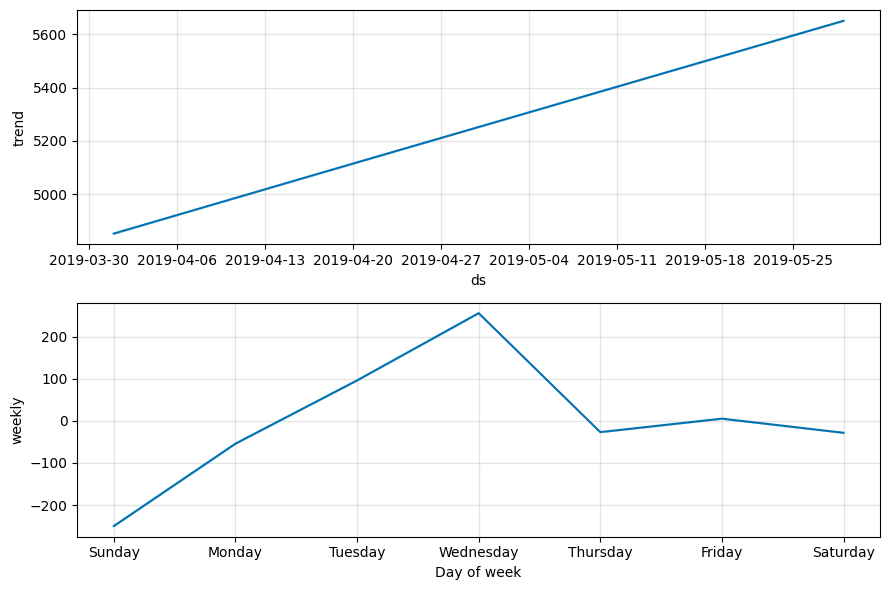

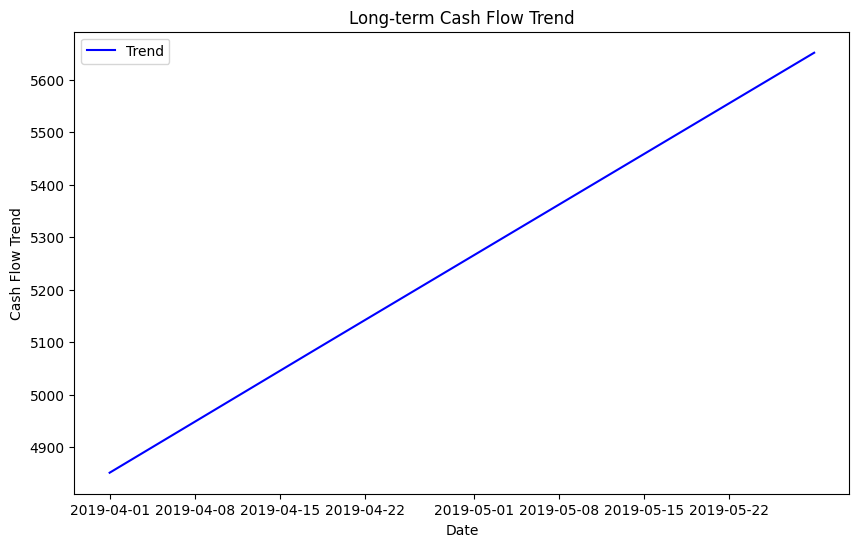

<Figure size 1000x600 with 0 Axes>

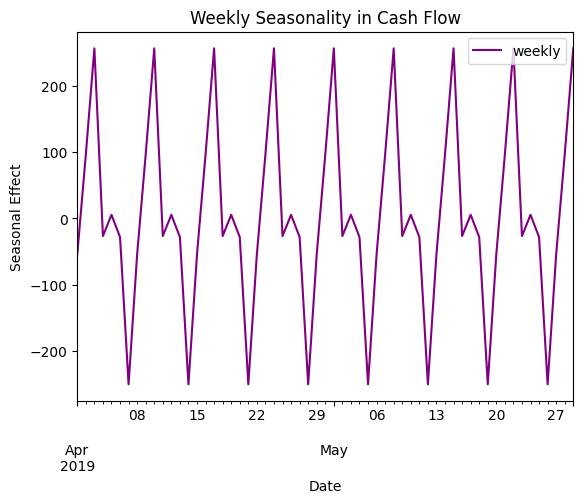

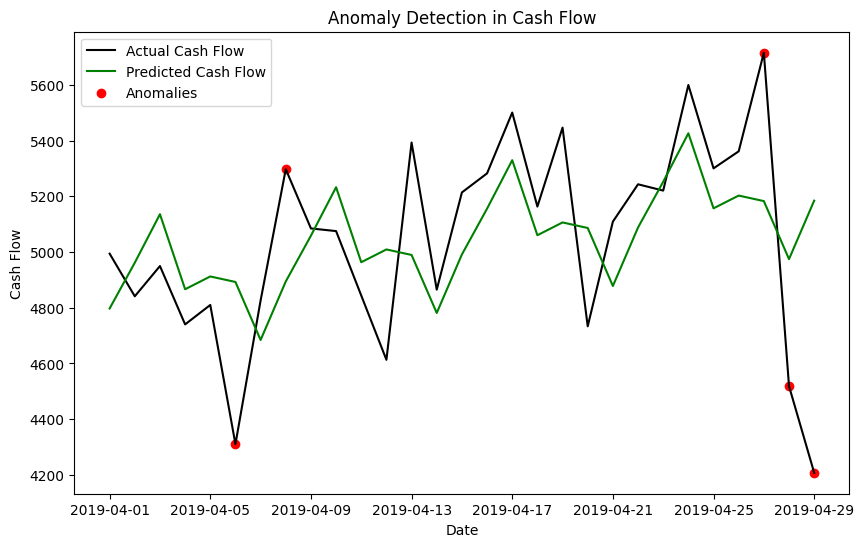

,ds,actual,yhat,yhat_lower,yhat_upper,anomaly
5,2019-04-06,4310.32,4892.405542,4478.809156,5295.019582,True
7,2019-04-08,5297.10,4894.190631,4483.352460,5283.647877,True
26,2019-04-27,5715.06,5182.598204,4770.150351,5589.554500,True
27,2019-04-28,4518.73,4974.345307,4587.743919,5396.149088,True
28,2019-04-29,4207.90,5184.227797,4764.920215,5585.354801,True


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract trend and seasonality components from the forecast
forecast_components = model.plot_components(forecast)

# 1. **Trend Analysis**
# Plotting only the trend component for clarity
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['trend'], label='Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Cash Flow Trend')
plt.title('Long-term Cash Flow Trend')
plt.legend()
plt.show()

# 2. **Seasonality Analysis**
# Weekly seasonality pattern
plt.figure(figsize=(10, 6))
forecast[['ds', 'weekly']].plot(x='ds', y='weekly', color='purple')
plt.title('Weekly Seasonality in Cash Flow')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.show()

# 3. **Anomaly Detection**
# Identifying anomalies where actual values deviate significantly from predictions
cash_flow_with_forecast = pd.merge(cash_flow_data_for_prophet.rename(columns={'y': 'actual'}), 
                                   forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
cash_flow_with_forecast['anomaly'] = (cash_flow_with_forecast['actual'] < cash_flow_with_forecast['yhat_lower']) | \
                                     (cash_flow_with_forecast['actual'] > cash_flow_with_forecast['yhat_upper'])

anomalies = cash_flow_with_forecast[cash_flow_with_forecast['anomaly']]

# Highlight anomalies on a plot
plt.figure(figsize=(10, 6))
plt.plot(cash_flow_with_forecast['ds'], cash_flow_with_forecast['actual'], label='Actual Cash Flow', color='black')
plt.plot(cash_flow_with_forecast['ds'], cash_flow_with_forecast['yhat'], label='Predicted Cash Flow', color='green')
plt.scatter(anomalies['ds'], anomalies['actual'], color='red', label='Anomalies', marker='o')
plt.xlabel('Date')
plt.ylabel('Cash Flow')
plt.title('Anomaly Detection in Cash Flow')
plt.legend()
plt.show()

# Display anomaly data for further review
anomalies
